# Accuracy 80%

In [26]:
import os
import time
import shutil
import librosa
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve\
,auc
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
print(f'tensorflow version: {tf.__version__}')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

tensorflow version: 2.7.0


In [27]:
tqdm_notebook.pandas()

## Import files and labels

In [52]:
train_df = pd.DataFrame(columns=['full_path', 'filename', 'mfcc', 'is_train', 'is_augmented', 'um_label'])
test_df = pd.DataFrame(columns=['full_path', 'filename', 'mfcc', 'is_train', 'is_augmented', 'um_label'])

In [53]:
path = 'model_dataset'
for filename in os.listdir(f'{path}/train/true/'):
    new_row = {'full_path': f'{path}/train/true/', 'filename': filename, 'is_train': True, 'is_augmented': False, 'um_label': 1}
    train_df = train_df.append(new_row, ignore_index = True)

for filename in os.listdir(f'{path}/train/self_collect_true/'):
    new_row = {'full_path': f'{path}/train/self_collect_true/', 'filename': filename, 'is_train': True, 'is_augmented': True, 'um_label': 1}
    train_df = train_df.append(new_row, ignore_index = True)
    
for filename in os.listdir(f'{path}/train/augmented_true/'):
    new_row = {'full_path': f'{path}/train/augmented_true/', 'filename': filename, 'is_train': True, 'is_augmented': True, 'um_label': 1}
    train_df = train_df.append(new_row, ignore_index = True)
    
for filename in os.listdir(f'{path}/train/false/'):
    new_row = {'full_path': f'{path}/train/false/', 'filename': filename, 'is_train': True, 'is_augmented': False, 'um_label': 0}
    train_df = train_df.append(new_row, ignore_index = True)

In [54]:
path = 'model_dataset'
for filename in os.listdir(f'{path}/test/true/'):
    new_row = {'full_path': f'{path}/test/true/', 'filename': filename, 'is_train': False, 'is_augmented': False, 'um_label': 1}
    test_df = test_df.append(new_row, ignore_index = True)

for filename in os.listdir(f'{path}/test/false/'):
    new_row = {'full_path': f'{path}/test/false/', 'filename': filename, 'is_train': False, 'is_augmented': False, 'um_label': 0}
    test_df = test_df.append(new_row, ignore_index = True)

## Undersampling

In [55]:
train_df.value_counts(['um_label'])

um_label
0           20590
1           14818
dtype: int64

In [56]:
test_df.value_counts(['um_label'])

um_label
0           5171
1           1200
dtype: int64

In [57]:
def undersampling_class(df, label_column, to_reduce_class, sample_number):
    true_df = df[df[label_column]==1]
    false_df = df[df[label_column]==0]
    
    if to_reduce_class == 0:
        false_df = false_df.sample(n=sample_number)
    else:
        true_df = true_df.sample(n=sample_number)
    
    return pd.concat([true_df, false_df], axis=0)

In [58]:
train_df = undersampling_class(train_df, 'um_label', 0,14_000)
test_df = undersampling_class(test_df, 'um_label', 0, 1200)

In [59]:
train_df.value_counts(['um_label'])

um_label
1           14818
0           14000
dtype: int64

In [60]:
test_df.value_counts(['um_label'])

um_label
0           1200
1           1200
dtype: int64

## Convert to MFCC

In [61]:
def extract_mfcc(df):
    try:
        folder_name = 'clips'
        audio, sr = librosa.load(f'{df["full_path"]}{df["filename"]}', sr=16000)
        mfcc = librosa.feature.mfcc(audio, sr, n_mfcc=13)
        return mfcc
    except:
        return None

In [62]:
%%time
train_df['mfcc'] = train_df.progress_apply(extract_mfcc, axis=1)
test_df['mfcc'] = test_df.progress_apply(extract_mfcc, axis=1)

  0%|          | 0/28818 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

CPU times: total: 5min 7s
Wall time: 3min 56s


In [63]:
X_train = np.stack(train_df['mfcc'].to_numpy())
y_train = train_df['um_label'].to_numpy().reshape(-1,1).astype('float32')

X_test = np.stack(test_df['mfcc'].to_numpy())
y_test = test_df['um_label'].to_numpy().reshape(-1,1).astype('float32')

In [64]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
input_shape

(13, 94, 1)

# Train model

In [65]:
def create_cnn_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (2,2), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2,2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [66]:
model = create_cnn_model(input_shape)

In [67]:
adam_optimizer = Adam(learning_rate=0.00005)

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam_optimizer)

In [68]:
%%time
num_epochs = 100
num_batch_size = 64

model_checkpoint = ModelCheckpoint(filepath='models/v8 (all).hdf5', 
                               verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

history = model.fit(X_train, 
          y_train, 
          batch_size=num_batch_size, 
          epochs=num_epochs, 
          validation_data=(X_test, y_test), 
          callbacks=[model_checkpoint, early_stop], 
          verbose=1)

Epoch 1/100
449/451 [============================>.] - ETA: 0s - loss: 0.6557 - accuracy: 0.6452
Epoch 00001: val_loss improved from inf to 0.70298, saving model to models\v8 (all).hdf5
451/451 [==============================] - 16s 34ms/step - loss: 0.6552 - accuracy: 0.6455 - val_loss: 0.7030 - val_accuracy: 0.5487
Epoch 2/100
449/451 [============================>.] - ETA: 0s - loss: 0.5459 - accuracy: 0.7092
Epoch 00002: val_loss improved from 0.70298 to 0.68768, saving model to models\v8 (all).hdf5
451/451 [==============================] - 15s 33ms/step - loss: 0.5457 - accuracy: 0.7092 - val_loss: 0.6877 - val_accuracy: 0.5929
Epoch 3/100
449/451 [============================>.] - ETA: 0s - loss: 0.4985 - accuracy: 0.7518
Epoch 00003: val_loss improved from 0.68768 to 0.68328, saving model to models\v8 (all).hdf5
451/451 [==============================] - 15s 34ms/step - loss: 0.4984 - accuracy: 0.7519 - val_loss: 0.6833 - val_accuracy: 0.6075
Epoch 4/100
449/451 [==============

Epoch 29/100
450/451 [============================>.] - ETA: 0s - loss: 0.1997 - accuracy: 0.9197
Epoch 00029: val_loss did not improve from 0.43578
451/451 [==============================] - 16s 36ms/step - loss: 0.1997 - accuracy: 0.9196 - val_loss: 0.4575 - val_accuracy: 0.8079
Epoch 30/100
449/451 [============================>.] - ETA: 0s - loss: 0.1993 - accuracy: 0.9199
Epoch 00030: val_loss did not improve from 0.43578
451/451 [==============================] - 15s 33ms/step - loss: 0.1992 - accuracy: 0.9200 - val_loss: 0.4861 - val_accuracy: 0.8042
Epoch 31/100
450/451 [============================>.] - ETA: 0s - loss: 0.1920 - accuracy: 0.9232
Epoch 00031: val_loss did not improve from 0.43578
451/451 [==============================] - 16s 35ms/step - loss: 0.1920 - accuracy: 0.9232 - val_loss: 0.4691 - val_accuracy: 0.8037
Epoch 32/100
449/451 [============================>.] - ETA: 0s - loss: 0.1839 - accuracy: 0.9273
Epoch 00032: val_loss did not improve from 0.43578
451/4

# Test Model

In [69]:
model = create_cnn_model(input_shape)

model.load_weights('models/v8 (all).hdf5')

In [70]:
def test_thresholds(X, y):
    fpr, tpr, thresholds = roc_curve(y, model.predict(X))
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % auc(fpr, tpr),
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    
    possible_thresholds = np.linspace(0, 1, num=20)
    df_metrics = pd.DataFrame()
    for threshold in possible_thresholds:
        y_pred = (model.predict(X) > threshold).astype("int32")
        df_metrics = df_metrics.append({
            'threshold': threshold,
            'accuracy': accuracy_score(y, y_pred),
            'f1_score': f1_score(y, y_pred)
        }, ignore_index=True)
        
    sns.lineplot(data=df_metrics.set_index('threshold'), palette="tab10", linewidth=2.5)
    
    return df_metrics

In [42]:
y_pred = (model.predict(X_test) > 0.2).astype("int32")
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'f1 score: {f1_score(y_test, y_pred)}')
confusion_matrix(y_test, y_pred)

Accuracy: 0.7503703703703704
f1 score: 0.7579022988505747


array([[ 971,  529],
       [ 145, 1055]], dtype=int64)

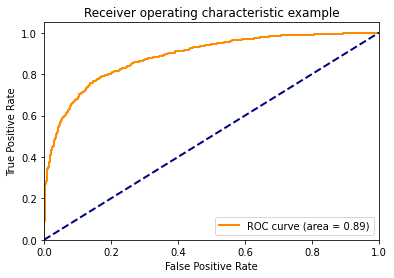

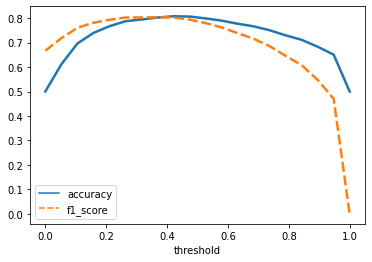

In [71]:
df_metrics = test_thresholds(X_test, y_test)

In [72]:
df_metrics.sort_values('accuracy', ascending=False)

,accuracy,f1_score,threshold
8,0.807500,0.802395,0.421053
9,0.806250,0.793792,0.473684
7,0.802083,0.803150,0.368421
10,0.798750,0.779754,0.526316
6,0.794167,0.802558,0.315789
11,0.789583,0.762129,0.578947
5,0.787083,0.802321,0.263158
12,0.777083,0.738642,0.631579
4,0.766667,0.792899,0.210526
13,0.766250,0.715661,0.684211
